In [43]:
import numpy as np
import pandas as pd
import datetime
import copy
import time
import os
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import operator

from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
from datetime import timedelta

tqdm.pandas()

`ADMISSIONS.parquet` describes the admit and discharge time, death time if died in the admission. Admission and discharge location in the hospital. Insurance, language, ethnicity and martial status. The diagnosis is also recorded, however keep in mind this diagnosis is assigned by the clinician/nurse at the time of admission (not a systematic ontology such as ICD9 code).

In [44]:
admissions_df = pd.read_parquet("data/ADMISSIONS.parquet")
admissions_df

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


The `admissions` table defines all `hadm_id` present in the database between June 1 2001 and October 10 2012.

Each row in the table contains a unique `hadm_id`, which represent a single patient's admission into the hospital. It is possible to have multiple `subject_id`, indicating that a single patient has had multiple admissions into the hospital. Information about `subject_id` can be viewed in the `PATIENTS` table.

In [45]:
print(f"Admissions begun on: {admissions_df.admittime.min()}")
print(f"Admissions ended on: {admissions_df.admittime.max()}\n")
print(f"Discharges begun on: {admissions_df.dischtime.min()}")
print(f"Discharges ended on: {admissions_df.dischtime.max()}")

Admissions begun on: 2100-06-07 19:59:00
Admissions ended on: 2210-08-17 17:13:00

Discharges begun on: 2100-06-09 17:09:00
Discharges ended on: 2210-08-24 19:43:00


In [46]:
admissions_df.subject_id.nunique()

46520

There are a total of 58967 admissions with a population of 46520.

`admission_type` is categorical data, with a possible of 4 values.

In [47]:
c = admissions_df.admission_type.value_counts()
p = admissions_df.admission_type.value_counts(normalize=True).mul(100).round(2)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
EMERGENCY,42071,71.34
NEWBORN,7863,13.33
ELECTIVE,7706,13.07
URGENT,1336,2.27


`admission_location` is categorical data, with a possible 9 values. 

In [48]:
c = admissions_df.admission_location.value_counts()[:5]
p = admissions_df.admission_location.value_counts(normalize=True).mul(100).round(2)[:5]
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
EMERGENCY ROOM ADMIT,22754,38.58
PHYS REFERRAL/NORMAL DELI,15079,25.57
CLINIC REFERRAL/PREMATURE,12032,20.40
TRANSFER FROM HOSP/EXTRAM,8456,14.34
TRANSFER FROM SKILLED NUR,273,0.46


`discharge_location` is categorical data, with a possible 17 values.

In [49]:
c = admissions_df.discharge_location.value_counts()[:5]
p = admissions_df.discharge_location.value_counts(normalize=True).mul(100).round(2)[:5]
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
HOME,18962,32.15
HOME HEALTH CARE,13963,23.68
SNF,7705,13.06
REHAB/DISTINCT PART HOSP,6429,10.90
DEAD/EXPIRED,5854,9.93


`insurance` is categorical data, with a possible 5 values.

In [50]:
c = admissions_df.insurance.value_counts()
p = admissions_df.insurance.value_counts(normalize=True).mul(100).round(2)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
Medicare,28215,47.84
Private,22582,38.29
Medicaid,5785,9.81
Government,1783,3.02
Self Pay,611,1.04


`hospital_expire_flag` is a binary value, where 1 represents a fatality and 0 represents alive.

In [51]:
c = admissions_df.hospital_expire_flag.value_counts()
p = admissions_df.hospital_expire_flag.value_counts(normalize=True).mul(100).round(2)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
0,53122,90.07
1,5854,9.93


`ethnicity` is categorical data, with a possible 41 values.

In [52]:
c = admissions_df.ethnicity.value_counts()[:5]
p = admissions_df.ethnicity.value_counts(normalize=True).mul(100).round(2)[:5]
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
WHITE,40996,69.51
BLACK/AFRICAN AMERICAN,5440,9.22
UNKNOWN/NOT SPECIFIED,4523,7.67
HISPANIC OR LATINO,1696,2.88
OTHER,1512,2.56


Let's observe the number of admissions on a monthy basis over a period of 10 years.

<AxesSubplot:title={'center':'Number of Admissions over time'}, xlabel='Year', ylabel='Number of Admissions'>

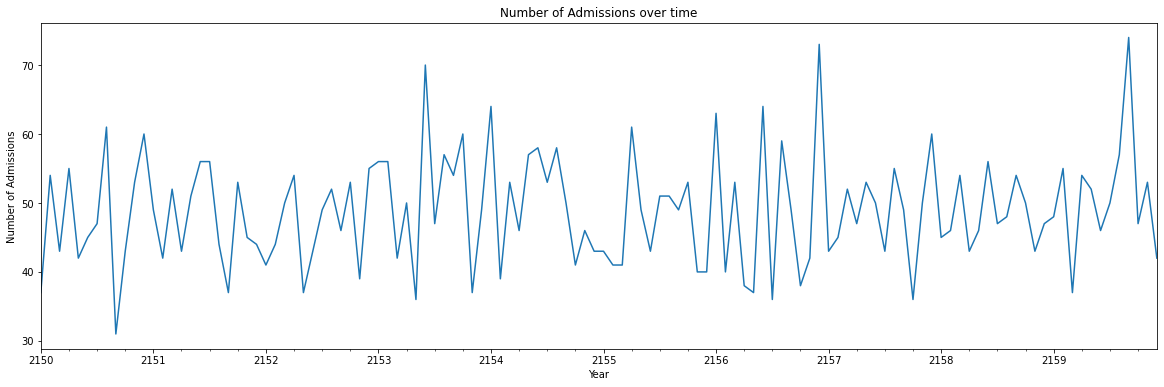

In [53]:
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])

mask = (admissions_df['admittime'] > '2150-01-01') & (admissions_df['admittime'] <= '2160-01-01')
admission5year = admissions_df.loc[mask]
admission5year['year_month'] = pd.to_datetime(admission5year['admittime']).dt.to_period('M')
admission5year.year_month.value_counts().sort_index().plot(figsize=(20,6), xlabel='Year', ylabel='Number of Admissions', title='Number of Admissions over time')

Now, let's examine the patients where `hospital_expire_flag=1`.

In [54]:
mortality = admissions_df[admissions_df.hospital_expire_flag == 1]
print(f"Number of in-hospital mortalities: {mortality.shape[0]}")

Number of in-hospital mortalities: 5854


In [55]:
mortality['deathtime_hours'] = (mortality['deathtime'] - mortality['admittime']) / timedelta(hours=1) # Number of hours between time of death and admission.
mortality.deathtime_hours.describe()

count    5854.000000
mean      243.481212
std       335.897574
min      -716.716667
25%        44.350000
50%       139.716667
75%       311.366667
max      4954.216667
Name: deathtime_hours, dtype: float64

Filter out patients who have a negative deathtime_hours, most likely an administrative error.

In [56]:
mortality = mortality[(mortality.hospital_expire_flag == 1) & (mortality.deathtime_hours >=0)]
mortality.deathtime_hours.describe() / 24 # (in days)

count    240.250000
mean      10.315157
std       14.023737
min        0.000000
25%        1.975521
50%        5.920139
75%       13.103993
max      206.425694
Name: deathtime_hours, dtype: float64

Out of the patients that have died after being admitted into the hospital, average death time after being admitted into the ICU is 10.315 days. Maximum death time was 206.42 days and minimum days was 0.

Let's see a boxplot of the death time in hours after being admitted to the ICU.

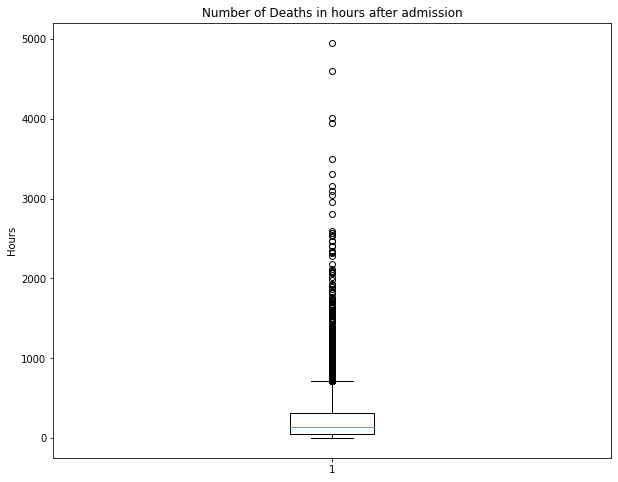

In [57]:
fig = plt.figure()
fig.set_size_inches(10,8)
plt.boxplot(mortality.deathtime_hours.tolist())
plt.ylabel("Hours ")
plt.title("Number of Deaths in hours after admission")
plt.show()

Let's view a histogram of the death times, truncated to 100 days.

Text(0.5, 0, 'Death time (days)')

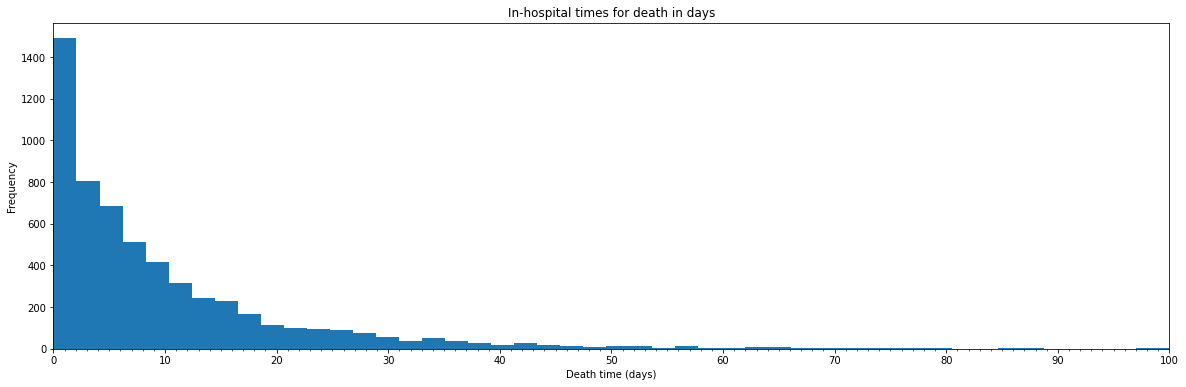

In [58]:
ax = plt.axes()
ax.set_xlim(0, 100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

mortality['deathtime_days'] = mortality['deathtime_hours'] / 24

mortality['deathtime_days'].plot(kind='hist', bins=100, figsize=(20,6),title='In-hospital times for death in days')
plt.xlabel('Death time (days)')

Does `admission_type` impact `hospital_expire_flag`?

Let's analyze each admission type individually.

In [59]:
admissions_emergency_deaths = admissions_df[(admissions_df.admission_type == 'EMERGENCY') & (admissions_df.hospital_expire_flag == 1)]
admissions_newborn_deaths = admissions_df[(admissions_df.admission_type == 'NEWBORN') & (admissions_df.hospital_expire_flag == 1)]
admissions_elective_deaths = admissions_df[(admissions_df.admission_type == 'ELECTIVE') & (admissions_df.hospital_expire_flag == 1)]
admissions_urgent_deaths = admissions_df[(admissions_df.admission_type == 'URGENT') & (admissions_df.hospital_expire_flag == 1)]

Text(0.5, 1.0, 'Number of Deaths by Admission Type')

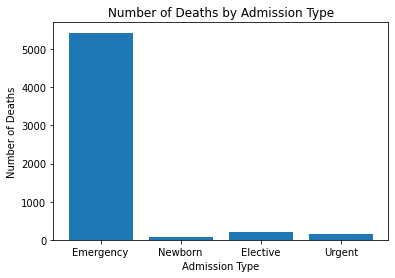

In [60]:
frequencies = [len(admissions_emergency_deaths), len(admissions_newborn_deaths), len(admissions_elective_deaths), len(admissions_urgent_deaths)]
xlabels = ["Emergency", "Newborn", "Elective", "Urgent"]

plt.bar(xlabels, frequencies)
plt.xlabel("Admission Type")
plt.ylabel("Number of Deaths")
plt.title("Number of Deaths by Admission Type")